## PS3 Programming exercise

- In this exercise, you will find the distance metric between the sequenses of images using the geometry of Grassmannian manifold.

### Dependency and initial settings

In [1]:
import numpy as np
import torch

from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

from torchvision.datasets.mnist import MNIST
from torchvision.utils import make_grid

torch.manual_seed(1)
np.random.seed(1)

/home/csj/anaconda3/envs/samsung/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Dataset

In [2]:
def load_MNIST_data(n_data=6000, sequence_length=10, shuffle=True):
    
    assert n_data % 10 == 0, f'n_data should be divisible by 10, got {n_data}'
    assert n_data <= 60000, f'n_data*set_size should be lower than 60000, got {n_data}.'
    
    n_data_per_label = int(n_data/10)
    
    dataset = MNIST(root='.', download=True)

    dataset.train = True
    data1, targets1 = dataset._load_data()
    dataset.train = False
    data2, targets2 = dataset._load_data()

    data = (torch.cat([data1, data2], dim=0).to(torch.float32) / 255).unsqueeze(1)
    targets = torch.cat([targets1, targets2], dim=0)
    
    data_ = []
    targets_ = []

    for label in range(10):
        data_i = data[targets==label][:n_data_per_label*sequence_length]

        dims = data_i.shape[1:]
        data_i = data_i.reshape(n_data_per_label, sequence_length, *dims).permute(0, 2, 3, 4, 1)
        targets_i = torch.ones(n_data_per_label) * label

        data_.append(data_i)
        targets_.append(targets_i)

    data = torch.cat(data_, dim=0)
    targets = torch.cat(targets_, dim=0)
    
    if shuffle:
        shuffle_idx = torch.randperm(len(data))
        data = data[shuffle_idx]
        targets = targets[shuffle_idx]
    
    return data, targets

In [3]:
# Make any necessary adjustments based on your computational resources (memory, cpu, etc).

n_data = 600             # Total number of data points (sequences) in the dataset, the code might be slow for n_data > 1000
sequence_length = 10     # The length of each data point (sequence). 

data, targets = load_MNIST_data(n_data=n_data, sequence_length=sequence_length, shuffle=True)
data.shape, targets.shape

100%|██████████| 9912422/9912422 [00:02<00:00, 4345786.26it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 55874397.52it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1590732.25it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1918095.93it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



(torch.Size([600, 1, 28, 28, 10]), torch.Size([600]))

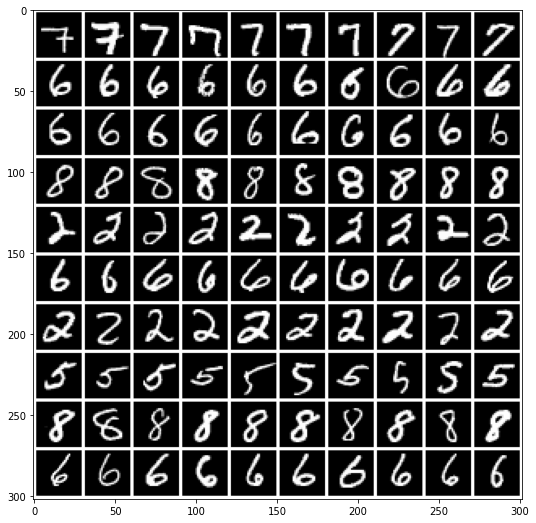

In [4]:
# Plot some data points. Each row of the plot represents a single data point (sequence). 
img = make_grid(data[:10].permute(0, 4, 1, 2, 3).flatten(0, 1), nrow=sequence_length, value_range=(0, 1), pad_value=1)
plt.figure(figsize=(9, 9))
plt.imshow(img.permute(1, 2, 0))
plt.show()

### Projection Mapping 

A sequence of images $X_i \in \mathbb{R}^{784 \times \texttt{sequence\_length}}$ is represented by a $k$-dimensional linear subspace spanned by an orthogonal basis matrix $Y_i \in \mathbb{R}^{784 \times k}$, s.t. $X_i X_i^T \approx Y_i \Lambda_i Y_i^T$, where $\Lambda_i$, $Y_i$ correspond to the matrices of the $k$ largest eigenvalues and eigenvectors respectively.

#### (a) Calculate $Y_i$ (Hint: use ```torch.linalg.eig()```)

In [5]:
# The flatten MNIST is 784 dim. vector, so N for the grassmannian manifold Gr(k, N) is 784.
# We need to select an approproate value k of Gr(k, N). 
k = 10 

X = data.flatten(1, 3).clone() # Dim. of (n_data, 784, sequence_length)

In [6]:
# You need to calculate Lambda, Y
# Lambda : Eigenvalues, dim. of (n_data, 784)
# Y : Eigenvectors, dim. of (n_data, 784, 784)
# the code will be slow.

# Lambda, Y = ######### CODE TO WRITE #########

################## Solution ##################
XXT = X@X.transpose(1, 2)
Lambda, Y = torch.linalg.eig(XXT)
##############################################

assert Lambda.shape == (n_data, 784), f'Dimensions mismatch: expected ({n_data}, 784), got {Lambda.shape}'
assert Y.shape == (n_data, 784, 784), f'Dimensions mismatch: expected ({n_data}, 784, 784), got {Y.shape}'

# Lambda and Y could be complex because of the numerical error
Lambda_real = Lambda.real.clone()
Y_real = Y.real.clone()

In [7]:
# Leave only k large eigenvalues in Y_real and Lambda_real

# Y_low, Lambda_low = ######### CODE TO WRITE #########

################## Solution ##################
Y_low = Y_real[:, :, :k].clone()
Lambda_low = Lambda_real[:, :k].clone()
##############################################

assert Lambda_low.shape == (n_data, k), f'Dimensions mismatch: expected ({n_data}, {k}), got {Lambda_low.shape}'
assert Y_low.shape == (n_data, 784, k), f'Dimensions mismatch: expected ({n_data}, 784, {k}), got {Y_low.shape}'

In [8]:
# Check approximation error : XX^T ~ Y \Lambda Y^T 
XXT_lowapprox = Y_low @ torch.diag_embed(Lambda_low) @ Y_low.transpose(1, 2)
print(f'Approximation Error: {torch.dist(XXT, XXT_lowapprox)}')

Approximation Error: 0.012732753530144691


#### (b) Calculate Projection Mapping 

- An element of $\mathcal{Gr}(k, N)$ is a linear subspace span($Y_i$), which is spanned by its orthonomal basis matrix $Y_i$.
- The elements on the Grassmannian manifold can be represented with the projection mapping $\Phi(Y_i)=Y_i Y_i^T$

In [9]:
# Calculate projection matric P 
# P : projection matrices, dim. of (Batch, 784, 784)

# P = ######### CODE TO WRITE #########

################## Solution ##################
P = Y_low @ Y_low.transpose(1, 2)
##############################################

assert P.shape == (n_data, 784, 784), f'Dimensions mismatch: expected ({n_data}, 784, 784), got {P.shape}'

#### (c) Training K-Neighbors classifier for MNIST classification

In [10]:
train_test_split = 0.7

idx_ = torch.randperm(n_data)
train_mask = idx_[:int(n_data*train_test_split)]
test_mask = idx_[int(n_data*train_test_split):]

##### Use Euclidean distances (Baseline)

In [11]:
X_KNC_euclidean = X.flatten(1, 2).clone().numpy()
Y_KNC_euclidean = targets.clone().numpy()

X_train_euclidean = X_KNC_euclidean[train_mask]
Y_train_euclidean = Y_KNC_euclidean[train_mask]

X_test_euclidean = X_KNC_euclidean[test_mask]
Y_test_euclidean = Y_KNC_euclidean[test_mask]

In [12]:
classifier_euclidean = KNeighborsClassifier(n_neighbors=5)
classifier_euclidean.fit(X_train_euclidean, Y_train_euclidean)
accu_euclidean = classifier_euclidean.score(X_test_euclidean, Y_test_euclidean)
print(f'Accuracy (Euclidean): {accu_euclidean*100:.2f}%')

Accuracy (Euclidean): 92.22%


##### Use geodesic distances on Grassmannian manifold

- Since the projection matrix $Y_i Y_i^T$ is a $D \times D$ symmetric matrix, a natural choice of inner product is $d(Y_1 Y_1^T, Y_2 Y_2^T) = \frac{1}{\sqrt{2}} ||Y_1 Y_1^T-Y_2 Y_2^T||_F$ where $||\cdot||_F$ denotes the maxtrix Frobenius norm.
- This is also called Projection Metric, and is able to approximate the true Grassmannian geodesic distance up to scale of $\sqrt{2}$. (one of the most popular metrics on the Grassmannian manifold)

In [13]:
# Set X_KNC for KNeighborsClassifier that uses geodesic distances on Grassmannian manifold
# X_KNC_geodesic : numpy array, dim. of (n_data, vector_dim)

# X_KNC_geodesic = ######### CODE TO WRITE #########

################## Solution ##################
X_KNC_geodesic = P.flatten(1, 2).clone().numpy()
##############################################
Y_KNC_geodesic = targets.clone().numpy()

X_train_geodesic = X_KNC_geodesic[train_mask]
Y_train_geodesic = Y_KNC_geodesic[train_mask]

X_test_geodesic = X_KNC_geodesic[test_mask]
Y_test_geodesic = Y_KNC_geodesic[test_mask]

In [14]:
classifier_geodesic = KNeighborsClassifier(n_neighbors=5)
classifier_geodesic.fit(X_train_geodesic, Y_train_geodesic)
accu_geodesic = classifier_geodesic.score(X_test_geodesic, Y_test_geodesic)
print(f'Accuracy (Geodesic): {accu_geodesic*100:.2f}%')

Accuracy (Geodesic): 100.00%


### References

- Huang, Zhiwu, et al. "Projection metric learning on Grassmann manifold with application to video based face recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.
- Hamm, Jihun, and Daniel D. Lee. "Grassmann discriminant analysis: a unifying view on subspace-based learning." Proceedings of the 25th international conference on Machine learning. 2008.
- Harandi, Mehrtash, et al. "Dictionary learning and sparse coding on Grassmann manifolds: An extrinsic solution." Proceedings of the IEEE international conference on computer vision. 2013.
